In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
from datetime import datetime
import random
import os

In [2]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# Hyper Parameters
BATCH_SIZE          = 32
LR                  = 1e-4  # learning rate
EPSILON             = 0.9   # greedy policy
GAMMA               = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY     = 5000
SEGREGATION_BIAS    = 20     # no. of non-terminal memories in batch

In [4]:
env = gym.make('CartPole-v0')
env = env.unwrapped
env.seed(seed);

In [5]:
XTRA_FEAT   = 3 #masscart, masspole, length
N_ACTIONS   = env.action_space.n 
N_STATES    = env.observation_space.shape[0] + XTRA_FEAT
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape
HIDDEN_LAYER = 50

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()

In [7]:
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        if r > 0: #non-terminal rewards
            # replace the old memory with new memory
            index = self.good_memory_counter % int(MEMORY_CAPACITY/2)
            self.good_memory[index, :] = transition
            self.good_memory_counter += 1
        
        else: #terminal rewards
            # replace the old memory with new memory
            index = self.bad_memory_counter % int(MEMORY_CAPACITY/2)
            self.bad_memory[index, :] = transition
            self.bad_memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(MEMORY_CAPACITY/2), int(SEGREGATION_BIAS))
        bad_sample_index  = np.random.choice(int(MEMORY_CAPACITY/2), int(BATCH_SIZE-SEGREGATION_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
dqn = D3QN()
NO_OF_EPISODES = int(MEMORY_CAPACITY/2) + 5000

In [9]:
print('\nCollecting experience...')
TIMESTEP_LIMIT = 200
total_time_steps = 0
time_rec = []
learn_start_flag = True
learn_start = 0
solve_metric = 195
upgrade_flag = False
upgrade_counter = 0
for i_episode in range(NO_OF_EPISODES):
    env.masscart = 1.0 * np.random.uniform(0.6,1.4)
    env.masspole = 0.1 * np.random.uniform(0.6,1.4)
    env.length   = 0.5 * np.random.uniform(0.6,1.4)
    
    s = env.reset()
    s = np.append(s, [env.masscart, env.masspole, env.length])
    ep_r = 0
    time_steps = 0
    while True:
#         env.render()
        time_steps += 1
        total_time_steps += 1
        a = dqn.choose_action(s)

        # take action
        s_, r, done, info = env.step(a)
        s_ = np.append(s_, [env.masscart, env.masspole, env.length])

        if done:
            if time_steps >= TIMESTEP_LIMIT:
                r = 1
            else:
                r = -1
           
        dqn.store_transition(s, a, r, s_)
        
        if dqn.good_memory_counter > MEMORY_CAPACITY/2 and dqn.bad_memory_counter > MEMORY_CAPACITY/2:
            dqn.learn()
            if learn_start_flag:
                print("Learning starts from EPISODE: ",i_episode)
                learn_start = i_episode
                learn_start_flag = False
        
        if done or time_steps >= TIMESTEP_LIMIT:
            time_rec = np.append(time_rec, time_steps)
            break
        s = s_
    
    #if minimum of episode length of last 100 episodes is greater than upgrade_metric=195
    if time_rec[-100:].min() > solve_metric:
        break
#         upgrade_counter += 1
#     else:
#         upgrade_counter = 0
        
#     if upgrade_counter > 110:
#         upgrade_counter = 0
#         print("Upgrading @ EPISODE: ", i_episode)
# #         upgrade_metric *= 2
# #         LR *= 0.1
#         EPSILON += 0.02
        


Learning starts from EPISODE:  2500


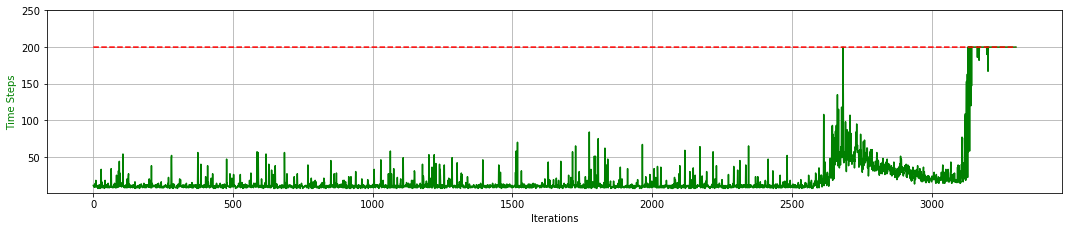

In [10]:
fig = plt.figure(figsize = (15,6))

ax2 = fig.add_subplot(2, 1, 1)
data = time_rec
ax2.plot(data, color = 'g')
ax2.plot(np.ones_like(data)*1500, 'g--')
ax2.plot(np.ones_like(data)*200, 'r--')

ax2.set_xlabel('Iterations',color = 'k')
ax2.set_ylabel('Time Steps',color = 'g')
ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

In [11]:
MODELNAME = './models/cartpole_v0-custom_xtra' + datetime.now().strftime("_%H_%M_%S")
print(MODELNAME)

./models/cartpole_v0-custom_xtra_21_40_48


In [12]:
torch.save(dqn.eval_net.state_dict(), MODELNAME)

In [13]:
env.close()

In [14]:
print("TOTAL TIMESTEPS: ", total_time_steps)

TOTAL TIMESTEPS:  82813


In [15]:
test_time_rec = []
for i_episode in range(1000):
    env.masscart = 1.0 * np.random.uniform(0.6,1.4)
    env.masspole = 0.1 * np.random.uniform(0.6,1.4)
    env.length   = 0.5 * np.random.uniform(0.6,1.4)
    xtra = [env.masscart, env.masspole, env.length]
    s = env.reset()
    s = np.append(s, xtra)
    time_steps = 0
    while True:
#         env.render()
        time_steps += 1
        a = dqn.choose_action(s)

        # take action
        s_, r, done, info = env.step(a)
        s_ = np.append(s_, xtra)

        if done or time_steps >= TIMESTEP_LIMIT:
            test_time_rec = np.append(test_time_rec, time_steps)
            break
        s = s_

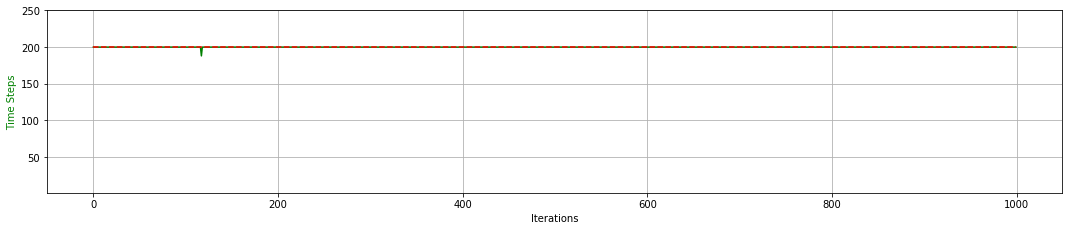

In [16]:
fig = plt.figure(figsize = (15,6))

ax2 = fig.add_subplot(2, 1, 1)
data = test_time_rec
ax2.plot(data, color = 'g')
ax2.plot(np.ones_like(data)*1500, 'g--')
ax2.plot(np.ones_like(data)*200, 'r--')

ax2.set_xlabel('Iterations',color = 'k')
ax2.set_ylabel('Time Steps',color = 'g')
ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()